In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# import os

# os.chdir('drive/MyDrive/three-phase-fidelity-wip')
# print(os.getcwd())

In [2]:
# # # # !pip install -r requirements.txt
# !pip install ipython==7.31.1
# !pip install importlib-metadata==4.10.0
# !pip install acv-exp
# !pip install hyperopt==0.27
# # # ## !pip freeze > requirements.txt

In [3]:
# !pip install lime
# !pip install shap
# !pip install anchor-exp
# !pip install hyperopt

In [4]:
# !pip install --requirement requirements.txt

In [5]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, classification_report, roc_auc_score, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold
import sklearn

import os
import joblib

import warnings
warnings.filterwarnings('ignore')

import statistics
import scipy
import math

import lime
import lime.lime_tabular
import shap
from learning import *
import pyAgrum
# from acv_explainers import ACXplainer


import seaborn as sns

import random

from tqdm import tqdm_notebook

import json

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
# !pip install acv-exp

In [7]:
def get_reg_features(cls):

    og_coef = cls.coef_
    if len(og_coef.shape) > 1:
        og_coef = og_coef[0]
    
    coef = [abs(val) for val in og_coef]
    
    bins = pd.cut(coef, 4, retbins = True, duplicates = "drop")
    q1_min = bins[1][-2]
    
    feat_pos = [i for i in range(len(coef)) if coef[i] > q1_min]
    
    return feat_pos

In [8]:
def get_knn_features(cls, instance, X_train):
    neighbours = cls.kneighbors(instance.reshape(1, -1), return_distance=False)[0]
    neighbourhood = [X_train[i] for i in neighbours]
    neighbourhood.append(instance)
    
    std = np.array(neighbourhood).std(0)
    
    bins = pd.cut(std, 4, retbins = True, duplicates = "drop")[1]
    lim = bins[1]
    
    feat_pos = [i for i in range(len(std)) if std[i] <= lim]
    
    return feat_pos

In [9]:
def get_nb_features(cls, instance):
    pred = cls.predict(instance.reshape(1, -1))
    means = cls.theta_[pred][0]
    std = np.sqrt(cls.var_[pred])[0]

    likelihoods = []
    
    for i in range(len(means)):
        lkhood = scipy.stats.norm(means[i], std[i]).logpdf(instance[i])
        #likelihoods.append(abs(lkhood))
        likelihoods.append(lkhood)
    
    bins = pd.cut(likelihoods, 4, retbins = True, duplicates = "drop")[1]
    lim = bins[-2]
    
#     bins = pd.cut(likelihoods, 10, retbins = True, duplicates = "drop")[1]
#     lim_1 = bins[-2]
#     lim_2 = bins[1]
    
#     sortedls = sorted(likelihoods, reverse=True)
#     pos = math.ceil(len(likelihoods)/4)
#     lim = likelihoods[pos]
    
    feat_pos = [i for i in range(len(likelihoods)) if likelihoods[i] >= lim]# or likelihoods[i] <= lim_2]
    
    return(feat_pos)

In [10]:
def get_tree_features(cls, instance):
    tree = cls.tree_
    lvl = 0
    left_child = tree.children_left[lvl]
    right_child = tree.children_right[lvl]

    feats = []
    
    while left_child != sklearn.tree._tree.TREE_LEAF and right_child != sklearn.tree._tree.TREE_LEAF:
        feature = tree.feature[lvl]
        feats.append(feature)
        
        if instance[feature] < tree.threshold[lvl]:
            lvl = left_child
        else:
            lvl = right_child
            
        left_child = tree.children_left[lvl]
        right_child = tree.children_right[lvl]
            
            
    feat_pos = set(feats)
    
    return feat_pos

In [11]:
def get_path_depths(tree, feat_list, cur_depth = 0, lvl = 0, depths = []):

    left_child = tree.children_left[lvl]
    right_child = tree.children_right[lvl]
    
    if left_child == sklearn.tree._tree.TREE_LEAF:
        depths.append(cur_depth)
        
    else:
        depths = get_path_depths(tree, feat_list, cur_depth+1, left_child, depths)
        depths = get_path_depths(tree, feat_list, cur_depth+1, right_child, depths)
    return depths

In [12]:
def get_shap_features(explainer, instance, cls, classification, exp_iter, feat_list):
    
    shap_exp = []
    
    pred = cls.predict(instance.reshape(1, -1))
    
    for i in range(exp_iter):
        if type(explainer) == shap.explainers._tree.Tree:
            exp = explainer(instance, check_additivity = False).values
        else:
            exp = explainer(instance.reshape(1, -1)).values
        
        #print(exp.shape)
        #print(exp)
        
        if exp.shape == (1, len(feat_list), 2):
            exp = exp[0]
            
        #print(exp.shape)
        
        if exp.shape == (len(feat_list), 2):
            exp = np.array([feat[pred] for feat in exp]).reshape(len(feat_list))
        elif exp.shape == (1, len(feat_list)) or exp.shape == (len(feat_list), 1):
            exp = exp.reshape(len(feat_list))
            
        #print(np.array(exp).shape)
            
        shap_exp.append(exp)
        
    #print(np.array(shap_exp).shape)
        
    if np.array(shap_exp).shape != (exp_iter, len(feat_list)):
        raise Exception("Explanation shape is not correct. It is", np.array(shap_exp).shape, "instead of the expected", (exp_iter, len(feat_list)))
    
#     if classification==True, type(explainer) == shap.explainers._tree.Tree:
#         shap_exp = []
#         for each in full_exp:
#             single_exp = [feat[0] for feat in each]
#             shap_exp.append(single_exp)
#     else:
#         shap_exp = full_exp
        
    avg_val = np.average(shap_exp, axis = 0)
    abs_val = [abs(val) for val in avg_val]
    
    #Get recall and precision for the average of shap values
    bins = pd.cut(abs_val, 4, retbins = True, duplicates = "drop")
    q1_min = bins[1][-2]

    sorted_val = np.copy(abs_val)
    sorted_val.sort()
    
    shap_features = [i for i in range(len(feat_list)) if abs_val[i] > q1_min]
    
    return shap_features

In [13]:
def get_lime_features(explainer, instance, cls, classification, exp_iter, feat_list):
    lime_exp = []
    
    for i in range(exp_iter):
        if classification==True:
            lime_exp.extend(explainer.explain_instance(instance, cls.predict_proba, 
                                                num_features=len(feat_list), labels=[0,1]).as_list())
        else:
            lime_exp.extend(explainer.explain_instance(instance, cls.predict, 
                                                num_features=len(feat_list), labels=[0,1]).as_list())
            
    weights = [[] for each in feat_list]
    for exp in lime_exp:
        feat = exp[0]
        if '<' in feat:
            feat = exp[0].replace("= ",'')
            parts = feat.split('<')
        elif '>' in feat:
            feat = exp[0].replace("= ",'')
            parts = feat.split('>')
        else:
            parts = feat.split("=")
        
        for part in parts:
            if part.replace('.','').replace(' ','').isdigit()==False:
                feat_name = part.replace(' ','')
        n = feat_list.index(feat_name)
        weights[n].append(exp[1])
    
    weights = np.transpose(weights)
    avg_weight = np.average(np.array(weights), axis = 0)
    abs_weight = [abs(weight) for weight in avg_weight]
    
    bins = pd.cut(abs_weight, 4, retbins = True, duplicates = "drop")
    q1_min = bins[1][-2]
    
    sorted_weight = np.copy(abs_weight)
    sorted_weight.sort()
    
    lime_features = [i for i in range(len(feat_list)) if abs_weight[i] >= q1_min]
    
    return lime_features

In [14]:
def get_linda_features(instance, cls, scaler, dataset, exp_iter, feat_list):
    label_lst = ["Negative", "Positive"]
    
    feat_pos = []
    lkhoods = []
    
    for i in range(exp_iter):
        [bn, inference, infoBN] = generate_BN_explanations(instance, label_lst, feat_list, "Result", 
                                                                       None, scaler, cls, save_to+"/"+cls_method+"/", dataset, show_in_notebook = False)
        
        ie = pyAgrum.LazyPropagation(bn)
        result_posterior = ie.posterior(bn.idFromName("Result")).topandas()
        result_proba = result_posterior.loc["Result", label_lst[instance['predictions']]]
        row = instance['original_vector']
        #print(row)

        likelihood = [0]*len(feat_list)

        for j in range(len(feat_list)):
            var_labels = bn.variable(feat_list[j]).labels()
            str_bins = list(var_labels)
            bins = []

            for disc_bin in str_bins:
                disc_bin = disc_bin.strip('"(]')
                cat = [float(val) for val in disc_bin.split(',')]
                bins.append(cat)

            for k in range(len(bins)):
                if k == 0 and row[j] <= bins[k][0]:
                    feat_bin = str_bins[k]
                elif k == len(bins)-1 and row[j] >= bins[k][1]:
                    feat_bin = str_bins[k]
                elif row[j] > bins[k][0] and row[j] <= bins[k][1]:
                    feat_bin = str_bins[k]

            ie = pyAgrum.LazyPropagation(bn)
            ie.setEvidence({feat_list[j]: feat_bin})
            ie.makeInference()
            
            result_posterior = ie.posterior(bn.idFromName("Result")).topandas()
            new_proba = result_posterior.loc["Result", label_lst[instance['predictions']]]
            #print(result_proba, new_proba)
            proba_change = result_proba-new_proba
            likelihood[j] = abs(proba_change)

        lkhoods.append(likelihood)
        
    bins = pd.cut(np.mean(lkhoods, axis=0), 4, retbins = True, duplicates = "drop")
    q1_min = bins[1][-2]

    #If fixing all features produces the same result for the class,
    #return all features
    if len(set(np.mean(lkhoods, axis=0)))==1:
        feat_pos.extend(range(len(feat_list)))
        print(lkhoods)
    else:
        feat_pos.extend(list(np.where(np.mean(lkhoods, axis=0) >= q1_min)[0]))

    feat_pos = set(feat_pos)
    #print(feat_pos)
    
    return feat_pos

In [15]:
def get_acv_features(explainer, instance, cls, X_train, y_train, exp_iter):
  instance = instance.reshape(1, -1)
  y = cls.predict(instance)

  feat_pos = []

  for i in range(exp_iter):
    sdp_importance, sdp_index, size, sdp = explainer.importance_sdp_rf(instance, y, X_train, y_train)
    feat_pos.extend(sdp_index[0, :size[0]])

  feat_pos = set(feat_pos)

  return feat_pos

In [16]:
def get_explanation_features(explainer, instance, cls, scaler, dataset, classification, exp_iter, xai_method, feat_list, X_train, y_train):
    if xai_method == "SHAP":
        feat_pos = get_shap_features(explainer, instance, cls, classification, exp_iter, feat_list)
        
    elif xai_method == "LIME":
        feat_pos = get_lime_features(explainer, instance, cls, classification, exp_iter, feat_list)
        
    elif xai_method == "LINDA":
        feat_pos = get_linda_features(instance, cls, scaler, dataset, exp_iter, feat_list)

    elif xai_method == "ACV":
        feat_pos = get_acv_features(explainer, instance, cls, X_train, y_train, exp_iter)
        
    explanation_features = [feat_list[i] for i in feat_pos]
    explanation_features = set(explanation_features)
        
    return explanation_features

In [17]:
def get_true_features(cls, instance, cls_method, X_train, feat_list):
    if cls_method == "decision_tree":
        feat_pos = get_tree_features(cls, instance)
        
    elif cls_method == "logit" or cls_method == "lin_reg":
        feat_pos = get_reg_features(cls)
        
    elif cls_method == "knn":
        feat_pos = get_knn_features(cls, instance, X_train)
    
    elif cls_method == "nb":
        feat_pos = get_nb_features(cls, instance)
        
    true_features = [feat_list[i] for i in feat_pos]
    true_features = set(true_features)
    
    #print(feat_pos)
    
    return true_features

In [18]:
# path to project folder
# please change to your own
PATH = os.getcwd()

dataset = "bike_sharing"
cls_method = "decision_tree"

classification = False
xai_method = "SHAP"

random_state = 22
exp_iter = 10

save_to = "%s/%s/" % (PATH, dataset)
dataset_folder = "%s/datasets/" % (save_to)
final_folder = "%s/%s/" % (save_to, cls_method)

#Get datasets
X_train = pd.read_csv(dataset_folder+dataset+"_Xtrain.csv", index_col=False, sep = ";")
y_train = pd.read_csv(dataset_folder+dataset+"_Ytrain.csv", index_col=False, sep = ";")
test_x = pd.read_csv(final_folder+"test_sample.csv", index_col=False, sep = ";").values
results = pd.read_csv(os.path.join(final_folder,"results.csv"), index_col=False, sep = ";")
actual = results["Actual"].values

with open(dataset_folder+"col_dict.json", "r") as f:
    col_dict = json.load(f)
f.close()

feat_list = [each.replace(' ','_') for each in X_train.columns]

In [19]:
cls = joblib.load(save_to+cls_method+"/cls.joblib")
scaler = joblib.load(save_to+"/scaler.joblib")

In [20]:
print(type(cls))

<class 'sklearn.tree._classes.DecisionTreeRegressor'>


In [21]:
results

,Actual,Prediction,LIME Precision,LIME Recall,SHAP Precision,SHAP Recall,ACV Precision,ACV Recall
0,531,384.0,1.000000,0.166667,1.0,0.033333,1.000000,0.233333
1,93,60.5,1.000000,0.466667,1.0,0.066667,0.714286,0.333333
2,2,7.0,0.625000,0.416667,1.0,0.083333,0.666667,0.333333
3,173,154.5,1.000000,0.200000,1.0,0.033333,0.857143,0.200000
4,254,401.0,1.000000,0.222222,1.0,0.037037,0.857143,0.222222
...,...,...,...,...,...,...,...,...
95,111,332.0,1.000000,0.208333,1.0,0.083333,0.666667,0.250000
96,72,68.5,1.000000,0.214286,1.0,0.035714,1.000000,0.250000
97,331,292.0,1.000000,0.320000,1.0,0.040000,0.875000,0.280000
98,8,3.0,0.250000,0.250000,1.0,0.125000,0.125000,0.125000


In [22]:
if xai_method == "SHAP":
  #  explainer = shap.explainers._permutation.Permutation(cls.predict_proba, X_train)
    if cls_method == "xgboost" or cls_method == "decision_tree":
        explainer = shap.Explainer(cls)
    elif cls_method == "nb":
        if classification:
            masker = shap.maskers._tabular.Independent(X_train.values, len(X_train))
            explainer = shap.Explainer(cls.predict_proba, masker)
        else:
            print("NB is classification only")
    elif cls_method == "logit" or cls_method == "lin_reg":
        masker = shap.maskers._tabular.Independent(X_train.values, len(X_train))
        explainer = shap.Explainer(cls, masker)
    else:
        explainer = shap.Explainer(cls, X_train)
    print(type(explainer))
    
elif xai_method == "LIME":
    if col_dict['discrete'] != None:
        cat_cols = [each.replace(' ','_') for each in col_dict['discrete']]
        col_inds = [feat_list.index(each) for each in cat_cols]
    else:
        col_inds = []
    
    if classification==True:
        class_names=['Negative','Positive']# negative is 0, positive is 1, 0 is left, 1 is right
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feat_list, 
                                                            class_names=class_names, categorical_features = col_inds,
                                                            discretize_continuous=False)
    else:
        class_names = ['Final Value']
        explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feat_list, 
                                                           class_names=class_names, discretize_continuous=True, 
                                                           categorical_features = col_inds, mode = "regression")
        
elif xai_method == "LINDA":
    test_dict = generate_local_predictions( test_x, results["Actual"].values, cls, scaler, None )
#    feat_list = feat_list+["Result"]

    explainer = None

elif xai_method == "ACV":
    explainer = joblib.load(save_to+cls_method+"/acv_explainer.joblib")

<class 'shap.explainers._tree.Tree'>


In [23]:
compiled_precision = []
compiled_recall = []

for i in tqdm_notebook(range(len(test_x))):
    instance = test_x[i]
    true_features = get_true_features(cls, instance, cls_method, X_train.values, feat_list)
    
    if xai_method == "LINDA":
        instance = test_dict[i]
    
    explanation_features = get_explanation_features(explainer, instance, cls, scaler, dataset, classification, exp_iter, xai_method, 
                                                    feat_list, X_train.values, y_train)
    
    #print("True Features: ", true_features)
    #print("Explanation Features: ", explanation_features)
    
    if len(explanation_features) == 0:
        recall = 0
        precision = 0
    else:
        recall = len(true_features.intersection(explanation_features))/len(true_features)
        precision = len(true_features.intersection(explanation_features))/len(explanation_features)
    
    compiled_precision.append(precision)
    compiled_recall.append(recall)
    
results[xai_method+" Precision"] = compiled_precision
results[xai_method+" Recall"] = compiled_recall

In [24]:
type(explainer)

shap.explainers._tree.Tree

In [25]:
true_features

{'hr_1',
 'hr_19',
 'hr_3',
 'hr_4',
 'hr_5',
 'hr_8',
 'hum',
 'mnth_10',
 'mnth_12',
 'mnth_4',
 'mnth_8',
 'temp',
 'weathersit_3',
 'weekday_3'}

In [26]:
recall

0.07142857142857142

In [27]:
explanation_features

{'hum'}

In [28]:
true_features

{'hr_1',
 'hr_19',
 'hr_3',
 'hr_4',
 'hr_5',
 'hr_8',
 'hum',
 'mnth_10',
 'mnth_12',
 'mnth_4',
 'mnth_8',
 'temp',
 'weathersit_3',
 'weekday_3'}

In [29]:
results

,Actual,Prediction,LIME Precision,LIME Recall,SHAP Precision,SHAP Recall,ACV Precision,ACV Recall
0,531,384.0,1.000000,0.166667,1.0,0.066667,1.000000,0.233333
1,93,60.5,1.000000,0.466667,1.0,0.066667,0.714286,0.333333
2,2,7.0,0.625000,0.416667,1.0,0.083333,0.666667,0.333333
3,173,154.5,1.000000,0.200000,1.0,0.033333,0.857143,0.200000
4,254,401.0,1.000000,0.222222,1.0,0.111111,0.857143,0.222222
...,...,...,...,...,...,...,...,...
95,111,332.0,1.000000,0.208333,1.0,0.041667,0.666667,0.250000
96,72,68.5,1.000000,0.214286,1.0,0.035714,1.000000,0.250000
97,331,292.0,1.000000,0.320000,1.0,0.080000,0.875000,0.280000
98,8,3.0,0.250000,0.250000,1.0,0.125000,0.125000,0.125000


In [30]:
print(np.mean(compiled_precision))
print(np.mean(compiled_recall))

0.99
0.08269155461355533


(0.0, 1.0)

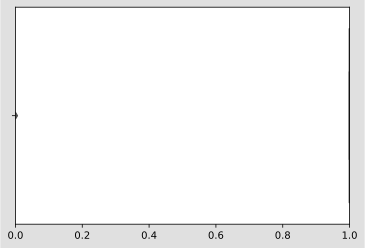

In [31]:
sns.boxplot(compiled_precision)
plt.xlim(0,1)

In [32]:
compiled_precision

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [33]:
results.to_csv(os.path.join(save_to, cls_method, "results.csv"), index = False, sep = ";")

In [34]:
instance

array([0.57142857, 0.5455    , 0.88      , 0.15786999, 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        ])

In [35]:
instance = test_dict[5+14]
label_lst = ["Negative", "Positive"]

NameError: name 'test_dict' is not defined

In [ ]:
[bn, inference, infoBN] = generate_BN_explanations(instance, label_lst, feat_list, "Result", 
                                                                       None, scaler, cls, save_to+"/"+cls_method+"/", dataset, show_in_notebook = False)
        
ie = pyAgrum.LazyPropagation(bn)
result_posterior = ie.posterior(bn.idFromName("Result")).topandas()
result_proba = result_posterior.loc["Result", label_lst[instance['predictions']]]
row = instance['original_vector']
#print(row)

likelihood = [0]*len(feat_list)

for j in range(len(feat_list)):
    var_labels = bn.variable(feat_list[j]).labels()
    str_bins = list(var_labels)
    bins = []

    for disc_bin in str_bins:
        disc_bin = disc_bin.strip('"(]')
        cat = [float(val) for val in disc_bin.split(',')]
        bins.append(cat)

    for k in range(len(bins)):
        if k == 0 and row[j] <= bins[k][0]:
            feat_bin = str_bins[k]
        elif k == len(bins)-1 and row[j] >= bins[k][1]:
            feat_bin = str_bins[k]
        elif row[j] > bins[k][0] and row[j] <= bins[k][1]:
            feat_bin = str_bins[k]

    ie = pyAgrum.LazyPropagation(bn)
    ie.setEvidence({feat_list[j]: feat_bin})
    ie.makeInference()

    result_posterior = ie.posterior(bn.idFromName("Result")).topandas()
    new_proba = result_posterior.loc["Result", label_lst[instance['predictions']]]
    #print(result_proba, new_proba)
    proba_change = result_proba-new_proba
    likelihood[j] = abs(proba_change)
print(likelihood)

In [ ]:
bins = pd.cut(likelihood, 4, retbins = True, duplicates = "drop")
q1_min = bins[1][-2]
q1_min

In [ ]:
feat_list[2]

In [ ]:
gnb.sideBySide(inference)

In [ ]:
compiled_recall

In [ ]:
print(true_features)
print(explanation_features)

In [ ]:
cls.predict(instance.reshape(1, -1))

In [ ]:
cls.predict_proba(instance.reshape(1, -1))

In [ ]:
cls.predict_log_proba(instance.reshape(1, -1))

In [ ]:
# #! git add .
# #! git commit -m "update notebook with white box acv code"
# ! git pull

In [ ]:
# !git add .
# !git commit -m "update notebook with acv code"

In [ ]:
# !git config --global user.email "n9455647@qut.edu.au"
# !git config --global user.name "Mythreyi-V"